In [2]:
import os, sys, time
import pandas as pd
import numpy as np
import pydicom as dcm
import matplotlib.pyplot as plt
from matplotlib import rcParams
import SimpleITK as sitk
import math
import cv2
rcParams['figure.figsize'] = 11.7,8.27
rcParams['font.size'] = 22

In [54]:
PATH = '/mnt/iDriveShare/Kayla/CBCT_images/kayla_extracted/'
# PATH_70 = '/mnt/iDriveShare/Kayla/CBCT_images/70Gy/'
# save_path = '/data/kayla/HNC_jsons/'
save_path = '/data/kayla/HNC_images/not_crop/'

In [4]:
from dicom_registration import *

In [5]:
patient = '147'
patient_path = PATH+ patient+'/'

# Functions

### Get Contours and Slice


In [7]:
def find_RS_file(path):
    for f in os.listdir(path):
        if 'RS' in f:
            return f

In [8]:
def find_ROI_names(RS, keyword=''):
    '''
    find_ROI_names  finds all contour names in RT Structure Set File containing keyword, 
                    while ignoring those containing 'nos' and 'z_'.
    
    :param RS: the RS file opened by pydicom
    :param keyword: The keyword to search the ROIs for. If blank returns all ROIs.
    
    :returns: list of ROI names containing keyword.
    '''
    ROI_names = []

    for seq in RS.StructureSetROISequence:
        roi_name = seq.ROIName
        if keyword.lower() in roi_name.lower() and 'nos' not in roi_name.lower() and 'z_' not in roi_name.lower():
            ROI_names.append(seq.ROIName)
    return ROI_names

In [9]:
def get_contour_from_ROI_name(ROI_name, RS):
    '''
    Gets the contour for the requested ROI_name in the RS file.
    '''
    for i, seq in enumerate(RS.StructureSetROISequence):
        if seq.ROIName == ROI_name:
            index = i
            break

    contour_coords = [] 
    
    for ROI_contour_seq in RS.ROIContourSequence[index].ContourSequence:
        contour_coords.append(ROI_contour_seq.ContourData) 
        
    return contour_coords

### Find contour slice and z for middle of structure

In [10]:
def get_all_ROI_contours(list_ROIs,RS):
    '''
    Get dictionary of contours for each of the ROIs in list_ROIs.
    '''
    dict_contours = {}
    z_lists = []
#     print(list_ROIs)

    for roi_name in list_ROIs:

        all_contours_ROI = get_contour_from_ROI_name(roi_name, RS)
        all_contours_ROI = sorted(all_contours_ROI, key=lambda x: x[2])
        dict_contours[roi_name] = all_contours_ROI
        z_lists.append(sorted([float(roi[2]) for roi in all_contours_ROI]))
    return dict_contours, z_lists

In [46]:
def get_avg_ROI_z_and_slice(z_lists):
    '''
    Gets the average (ie middle) z-value of the set of contour slices.
    
    TO DO: divide by zero error encountered when submandibular gland contour doesn't exist.
    '''
    z_avg = 0

    for z_list in z_lists:
        z_avg += (np.sum(z_list)/len(z_list))

    z_avg = z_avg/len(z_lists)
    roi_slice = np.argmin(abs(z_lists[0] - z_avg)) #TO DO: what if not in this list? but it should ebf ine
    z_smg = z_lists[0][roi_slice]

    return roi_slice, z_smg

### Find image slice corresponding to above z


In [47]:
def get_start_position_sitk(sitk_image):

    
#     pixels = sitk.GetArrayFromImage(sitk_image)
    origin = sitk_image.GetOrigin()
    spacing = sitk_image.GetSpacing()
    
    return origin[0], origin[1], origin[2], spacing

In [13]:
def get_start_position_dcm(CT_path):
    positions = []
    for f in [file for file in os.listdir(CT_path) if 'CT' in file]:
        d = dcm.dcmread(CT_path+f)
        positions.append(d.ImagePositionPatient)

    # dcm.dcmread(patient_path + '20190712_CT_05_JUL_2019/CT.1.2.246.352.221.461737655324817980512720114456327223461.dcm')

    positions = sorted(positions, key=lambda x: x[-1])
    start_z = positions[0][2]
    start_x = positions[0][0]
    start_y = positions[0][1]
    pixel_spacing = d.PixelSpacing
    
    return start_x, start_y, start_z, spacing

In [14]:
def get_image_slice(start_z, z_smg, spacing):
    img_slice = int((abs(start_z - z_smg)/spacing[2]))
    return img_slice

### Plotting CT and CBCT with contour

In [15]:
def get_ROI_pixel_array(roi_array,start_x,start_y,pixel_spacing):
    '''
    Get the pixel positions (rather than the x,y coords) of the contour array so it can be plotted.
    '''
#     roi_array = dict_contours[subgland_ROI_names[0]][roi_slice]
    x = []
    y = []

    for i in range(0,len(roi_array),3):
        x.append((roi_array[i] - start_x)/pixel_spacing[0])
        y.append((roi_array[i+1] - start_y)/pixel_spacing[1]) 
        
    return x, y

In [16]:
def plot_ROI(image_array, x, y):
    plt.imshow(image_array)
    if len(x)==1 and len(y)==1:
        plt.plot(x,y,'ro')
    else:
        plt.plot(x, y, 'r-')
#     plt.plot(256,256,'mo')
    plt.show()

In [43]:
# Functions for if you don't crop (this was the original code setup to crop according to isocentre, but it's not always centered)

In [17]:
def plot_cropped_multi(json_dict):
    fig = plt.figure(figsize=(20, 10))
    
    
    CT_list = list(json_dict.keys())
    replan=False
    if len(CT_list) > 1: replan = True
    CBCT_list = list(json_dict[CT_list[0]].keys())
    columns = 3
    rows = 1
    rows_replan = 2 if replan else rows

    for i in range(1, columns*rows +1):
        try:
            img = json_dict[CT_list[0]][CBCT_list[i-1]]['pixel_array']
        except:
            break
        fig.add_subplot(rows_replan, columns, i)
        plt.title(CBCT_list[i-1], fontsize=12)
        plt.imshow(img)
        iso = json_dict[CT_list[0]][CBCT_list[i-1]]['iso_reg']
        spacing = json_dict[CT_list[0]][CBCT_list[i-1]]['spacing']
        origin = json_dict[CT_list[0]][CBCT_list[i-1]]['origin_crop']
        iso_ind_x = (iso[0]-origin[0])/spacing[0]
        iso_ind_y = (iso[1]-origin[1])/spacing[1]
        plt.plot(iso_ind_x,iso_ind_y,'ro')
        
        # plot FOV circle
#         circ1 = Circle((x_i-pixel_left, y_i-pixel_top ),diam/new_spacing/2 ,edgecolor='yellow', lw=1,fill=False)


#     if replan:

#         for i in range(columns*rows +1, columns*rows_replan +1):
#             img = sitk.GetArrayViewFromImage(image_dict[CT_list[1]]['resampled_CBCTs'][i-(columns*rows+1)])[75]
#         #     img = sitk.GetArrayViewFromImage(resampled_cbct_list_2[i-1])[75]
#             fig.add_subplot(rows_replan, columns, i)
#             plt.title(image_dict[CT_list[1]]['CBCTs'][i-(columns*rows+1)], fontsize=12)
#             plt.imshow(img[125:375,150:360])

    plt.show()


### Save to JSON

In [37]:
def generate_json(patient_path, image_dict,plot=True, crop=False):
    '''
    Generate a dictionary with all cropped/registered slice image data.
    '''
    json_dict = {}
    for CT in image_dict:
        
        # For each CT, find the corresponding RS file
        CT_path = patient_path + CT + "/"
        RS_file = find_RS_file(CT_path)
        RS = dcm.dcmread(CT_path+RS_file)

        # Get the middle z of the submandibular contours
        subgland_ROI_names = find_ROI_names(RS,keyword='sub')
        print(subgland_ROI_names)
        dict_contours, z_lists = get_all_ROI_contours(subgland_ROI_names, RS)
        roi_slice, z_smg = get_avg_ROI_z_and_slice(z_lists)

        json_dict[CT] = {}
        
        for i, CBCT in enumerate(image_dict[CT]['CBCTs']):
            CBCT_sitk = image_dict[CT]['resampled_CBCTs'][i]

            # Get the CBCT slice corresponding to the middle z
            start_x, start_y, start_z, spacing = get_start_position_sitk(CBCT_sitk)
            slice_ind = get_image_slice(start_z, z_smg, spacing)
            final_slice = CBCT_sitk[:,:,slice_ind]

            isocenter = image_dict[CT]['isocenters'][i]
            pixel_isocenter = CBCT_sitk.TransformPhysicalPointToContinuousIndex(isocenter)

            #crop bounds
            if crop:
                pixel_left = int(round(pixel_isocenter[0]-(256/2)))
                pixel_right = int(round(pixel_isocenter[0]+(256/2)))
                pixel_top = int(round(pixel_isocenter[0]-(256/2)))
                pixel_bottom = int(round(pixel_isocenter[0]+(256/2)))

                img_array = sitk.GetArrayFromImage(final_slice)
                cropped_array = img_array[pixel_top:pixel_bottom,pixel_left:pixel_right]
            else:
                cropped_array = sitk.GetArrayFromImage(final_slice)
    
            # Fill in the json dict with info for each CBCT
            json_dict[CT][CBCT] = {}
            json_dict[CT][CBCT]['origin_original'] = CBCT_sitk.GetOrigin()
            if crop:
                json_dict[CT][CBCT]['origin_crop'] = CBCT_sitk.TransformIndexToPhysicalPoint((pixel_left,pixel_top,slice_ind))
            else:
                json_dict[CT][CBCT]['origin_crop'] = json_dict[CT][CBCT]['origin_original']
            json_dict[CT][CBCT]['iso_reg'] = isocenter
            if crop:
                json_dict[CT][CBCT]["crop_bounds"] = [pixel_left,pixel_right,pixel_top,pixel_bottom]
            #     json_dict[CT][CBCT]['size'] = image_dict[CT]['resampled_CBCTs'][i].GetSize()
            json_dict[CT][CBCT]['spacing'] = CBCT_sitk.GetSpacing()
            json_dict[CT][CBCT]['direction']  = CBCT_sitk.GetDirection()
            json_dict[CT][CBCT]['pixel_array'] = cropped_array.tolist()
            
        if plot: plot_cropped_multi(json_dict)
    return json_dict


In [48]:
def save_json(json_dict, patient_path,save_path):
    '''
    Saves a JSON for each patient containing the cropped and registered image slice for each CBCT fx and other image info.
    '''
    with open(save_path+patient_path.split("/")[-2]+'.json', "w") as outfile:
        json.dump(json_dict, outfile)

In [51]:
def generate_single_slice_data(list_patients,PATH,save_path):
    '''
    Generates single slices for all patients.
    '''
    for patient in list_patients:
        patient_path = PATH+ str(patient)+'/'
        print(patient_path)
        image_dict = {}
        json_dict = {}
        
        image_dict = register_patient(patient_path, True)
        json_dict = generate_json(patient_path,image_dict)
        
        save_json(json_dict, patient_path,save_path)
        
        

### Generate slice data for single patient

In [ ]:
image_dict = register_patient(patient_path, True)

['Glnd_Submand_R', 'Glnd_Submand_L']


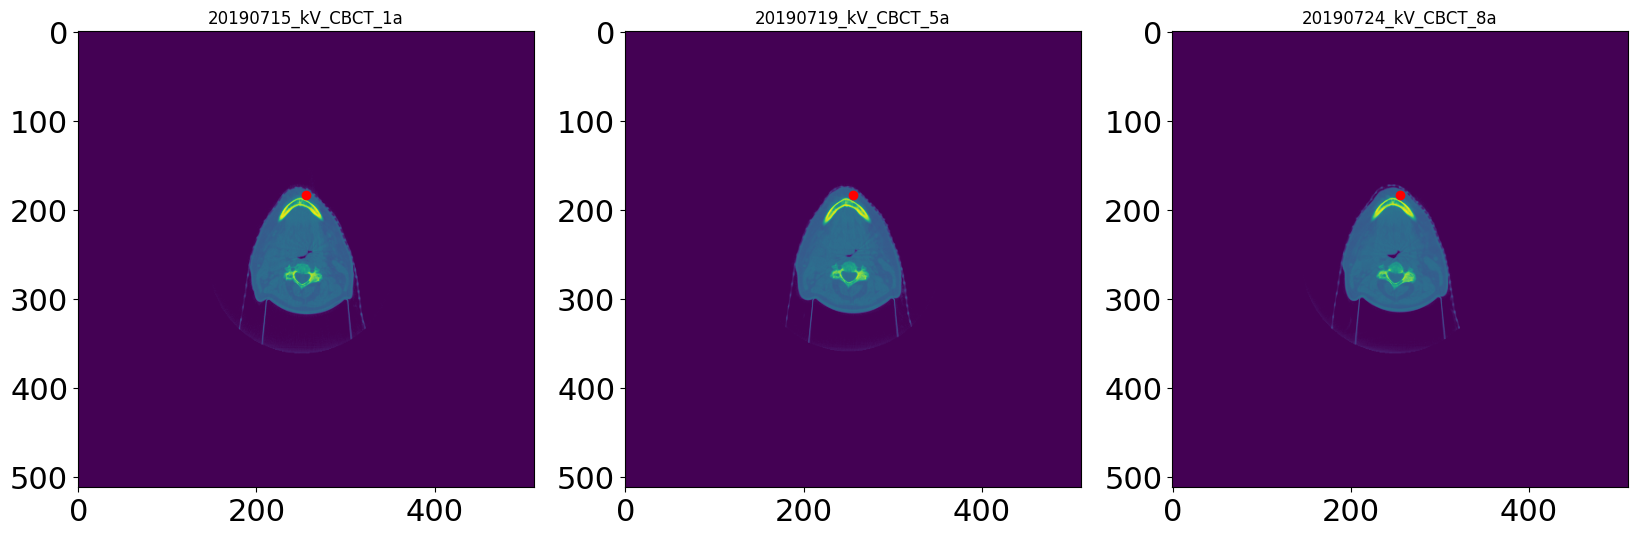

In [55]:
json_dict = generate_json(patient_path,image_dict)
save_json(json_dict, patient_path,save_path)


### Generate slice data for all patients

In [ ]:
list_patients = sorted(os.listdir(PATH),key=int)
generate_single_slice_data(list_patients, PATH)

# Use functions below if you are cropping

In [33]:
def find_body_mask(pixel_array,threshold=70):
    '''
    Finds mask of the body on single slice
    '''
    arr = np.array(pixel_array)

    if arr.max() > 2000:
        img = ((arr - arr.min()) * (1/(2000 - arr.min()) * 255)).astype('uint8')
    else:
        img = ((arr - arr.min()) * (1/(arr.max() - arr.min()) * 255)).astype('uint8')

    cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)

    ret, thresh = cv2.threshold(img,threshold, 255, cv2.THRESH_BINARY)
    
    canvas = np.zeros((256,256),np.uint8)
    contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cnt = sorted(contours, key=lambda x: cv2.contourArea(x),reverse=True)    
    
    mask = np.zeros(img.shape, np.uint8)
    cv2.drawContours(mask, cnt, 0, 255, -1)
  
    return mask

In [34]:
def get_headrest_center_pixels(mask):
    '''
    Find the bottom center of the head mask array
    '''
    # Finding the first row from bottom with non-zero (non -1000) pixel
    height = len(mask)

    for i,row in enumerate(reversed(mask)):
        if np.any(row):
            head_rest_row = height - i - 1
            break

    # Find middle column of first row with pixels 
    indices = []
    for ind, pixel in enumerate(mask[-i-1]):
        if pixel != 0:
            indices.append(ind)

    middle_col = int(np.mean(indices)) # rounds down
    plt.imshow(mask)
    plt.plot(middle_col,head_rest_row,'m.')
    
    hr_col = middle_col
    hr_row = head_rest_row
    
    # Define the crop region
    l = hr_col - 128
    r = hr_col + 128
    b = hr_row + 64
    t = hr_row - 192
    
    x = [l,l,r-1,r-1,l]
    y = [b-1,t,t,b-1,b-1]
    plt.plot(x,y,'c-')
    
    plt.plot([l,r],[head_rest_row,head_rest_row],'m--')
    plt.plot([middle_col,middle_col],[t,b], 'm--')
            
    return head_rest_row, middle_col

In [36]:
def plot_cropped_multi_v2(json_dict,legacy=False):
    fig = plt.figure(figsize=(20, 10))
    
    
    CT_list = list(json_dict.keys())
    replan=False
    if len(CT_list) > 1: replan = True
    CBCT_list = list(json_dict[CT_list[0]].keys())
    columns = 3
    rows = 1
    rows_replan = 2 if replan else rows

    for i in range(1, columns*rows +1):
        try:
            img = json_dict[CT_list[0]][CBCT_list[i-1]]['pixel_array']
        except:
            break
        fig.add_subplot(rows_replan, columns, i)
        plt.title(CBCT_list[i-1], fontsize=12)
        plt.imshow(img)
        iso = json_dict[CT_list[0]][CBCT_list[i-1]]['iso_reg']
        spacing = json_dict[CT_list[0]][CBCT_list[i-1]]['spacing']
        origin = json_dict[CT_list[0]][CBCT_list[i-1]]['origin_crop']
        
#         print(legacy)
        if not legacy:
            iso_ind_x = (iso[0]-origin[0])/spacing[0]
            iso_ind_y = (iso[1]-origin[1])/spacing[1]
            plt.plot(iso_ind_x,iso_ind_y,'co')
        plt.plot(256/2,256/2,'ro')

        plt.plot(128,192,'mo')
        

    if replan:

        for i in range(columns*rows +1, columns*rows_replan +1):
            try:
                img = json_dict[CT_list[0]][CBCT_list[i-1]]['pixel_array']
            except:
                break
            fig.add_subplot(rows_replan, columns, i)
            plt.title(CBCT_list[i-1], fontsize=12)
            plt.imshow(img)
            iso = json_dict[CT_list[0]][CBCT_list[i-1]]['iso_reg']
            spacing = json_dict[CT_list[0]][CBCT_list[i-1]]['spacing']
            origin = json_dict[CT_list[0]][CBCT_list[i-1]]['origin_crop']
            if not legacy:
                iso_ind_x = (iso[0]-origin[0])/spacing[0]
                iso_ind_y = (iso[1]-origin[1])/spacing[1]
                plt.plot(iso_ind_x,iso_ind_y,'co')
            plt.plot(256/2,256/2,'ro')

            plt.plot(128,192,'mo')


    plt.show()


In [56]:
def generate_json_v2(patient_path, image_dict,legacy=False,crop_same=True,plot=True):
    json_dict = {}

    reference_CT = [CT for CT in image_dict if image_dict[CT]['isReference']][0] 
#     print(reference_CT) 
    CT_path = patient_path + reference_CT + "/" 
    RS_file = find_RS_file(CT_path) 

    RS = dcm.dcmread(CT_path+RS_file) 
    subgland_ROI_names = find_ROI_names(RS,keyword='sub') 
    dict_contours, z_lists = get_all_ROI_contours(subgland_ROI_names, RS) 
    roi_slice, z_smg = get_avg_ROI_z_and_slice(z_lists) 

    j=0
    
    for j, CT in enumerate(image_dict):

        json_dict[CT] = {}
        
        for i, CBCT in enumerate(image_dict[CT]['CBCTs']):
            CBCT_sitk = image_dict[CT]['resampled_CBCTs'][i]
            
            if i==0 and j==0: 
                start_x, start_y, start_z, spacing = get_start_position_sitk(CBCT_sitk)  
                slice_ind = get_image_slice(start_z, z_smg, spacing) # just do this on the CT? 

            final_slice = CBCT_sitk[:,:,slice_ind]

            isocenter = image_dict[CT]['isocenters'][i]

            
            img_array = sitk.GetArrayFromImage(final_slice)
            if (crop_same and i==0 and j==0) or not crop_same: 
                mask = find_body_mask(img_array)
                hr_row,hr_col = get_headrest_center_pixels(mask)

                left_index = hr_col - 128
                right_index = hr_col + 128
                bottom_index = hr_row + 64
                top_index = hr_row - 192

            
            cropped_array = img_array[top_index:bottom_index,left_index:right_index]

            json_dict[CT][CBCT] = {}
            json_dict[CT][CBCT]['origin_original'] = CBCT_sitk.GetOrigin()
            json_dict[CT][CBCT]['origin_crop'] = CBCT_sitk.TransformIndexToPhysicalPoint((left_index,top_index,slice_ind))
            json_dict[CT][CBCT]['iso_reg'] = isocenter
            json_dict[CT][CBCT]["crop_bounds"] = [left_index,right_index,top_index,bottom_index]
            json_dict[CT][CBCT]['spacing'] = CBCT_sitk.GetSpacing()
            json_dict[CT][CBCT]['direction']  = CBCT_sitk.GetDirection()
            json_dict[CT][CBCT]['pixel_array'] = cropped_array.tolist()
        if plot: plot_cropped_multi_v2(json_dict,legacy)
    return json_dict


In [25]:
def generate_single_slice_data_v2(list_patients,PATH,save_path):
    for patient in list_patients:
        patient_path = PATH+ str(patient)+'/'
        print(patient_path)
        image_dict = {}
        json_dict = {}
        
        try:
            image_dict = dicom_registration.register_patient(patient_path, False)
            json_dict = generate_json_v2(patient_path,image_dict)
            save_json(json_dict, patient_path,save_path)
        except Exception as e:
            print("SKIPPING PATIENT ",patient, 'due to error: ',e)
        

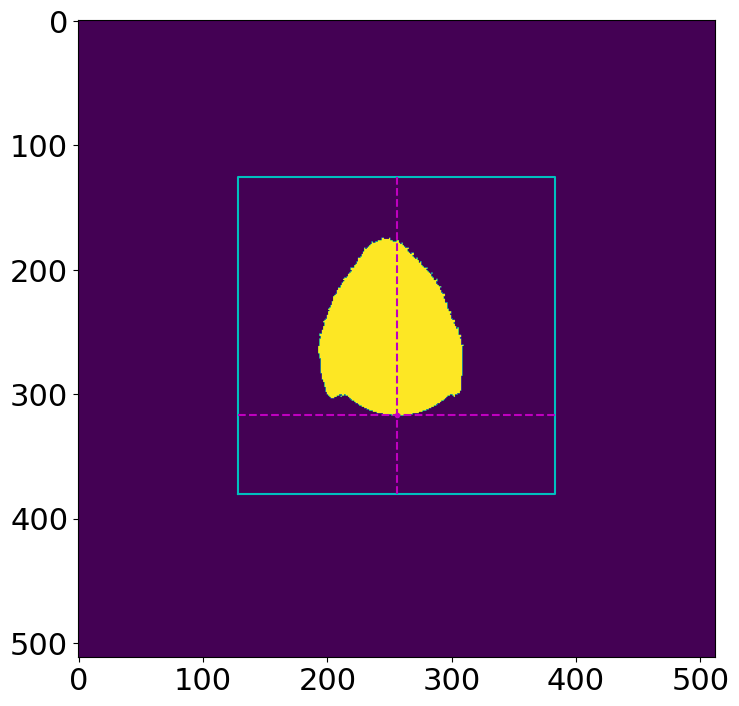

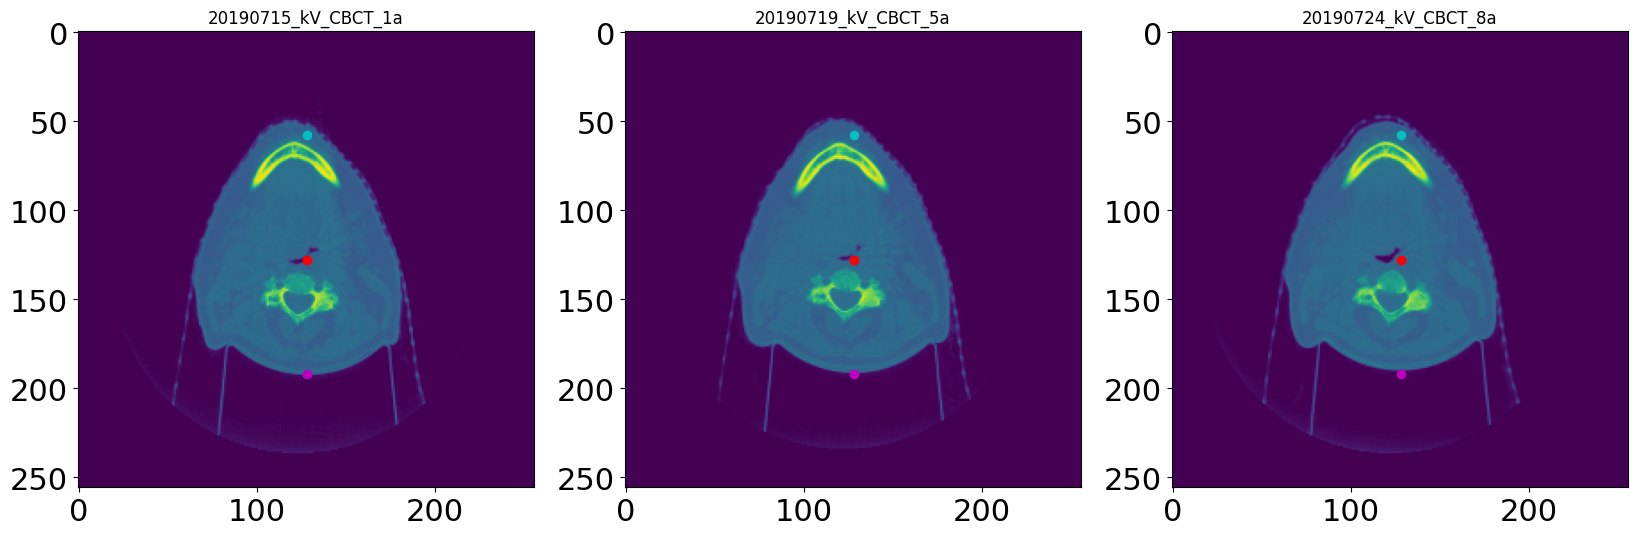

In [42]:
# Individual Patient
json_dict = generate_json_v2(patient_path,image_dict)
save_json(json_dict, patient_path,save_path)

In [28]:
# All patients
list_patients = sorted(os.listdir(PATH),key=int)
generate_single_slice_data_v2(list_patients, PATH)

In [45]:
# Uncomment and run if you need to refresh python code in dicom_registration.py
# import dicom_registration
# %load_ext autoreload
# %autoreload 2


# import importlib
# importlib.reload(dicom_registration)

## Testing:


In [ ]:
list_no_sub = ['602','641','646','660','661','671','677','702','703','713','737','743','744','711','811','812','822','831',
               '834','837','845','846','895','906','907','916','918','919']

In [ ]:
list_patients = sorted(os.listdir(PATH),key=int)
jsons_produced = [f.split(".")[0] for f in os.listdir('/data/kayla/HNC_images/HNC_jsons')]
remove_temp = ['19','59','108','432','436','454','460','495','600','607','623','632','641','646','660','666','671','685','700','702','703','713','714','734','740','744']
list_good_patients = [p for p in list_patients if p not in jsons_produced and p not in remove_temp]

In [ ]:
generate_single_slice_data_v2(list_good_patients, PATH)